### EDA / Regression Viability
- Data Clean up
- Apply Inflation
- Log Transform
- Apply inflation to Gross - previously only done on budget
- Dummy Coding
- Linear Regression Models Pre-Post Log Transform
- Correlation Charts / Pair Plots

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import re
import cpi
from datetime import datetime

In [2]:
#bring data together
batch1 = pd.read_csv('/Users/jennihawk/Desktop/Thriller Project/Movie_Linear_Regression/thriller_csv_files/thrillers_1_to_350_year_budget.csv')
batch2 = pd.read_csv('/Users/jennihawk/Desktop/Thriller Project/Movie_Linear_Regression/thriller_csv_files/thrillers_351_700rows.csv')
batch3 = pd.read_csv('/Users/jennihawk/Desktop/Thriller Project/Movie_Linear_Regression/thriller_csv_files/thrillers_751_1150rows.csv')

all_movies = [batch1, batch2, batch3]

movie_df = pd.concat(all_movies)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
movie_df.reset_index(drop=True, inplace=True)

In [5]:
#movie_df

#### Replace current budget column with new, updated column values

In [6]:
all_budget = pd.read_csv('/Users/jennihawk/Desktop/Thriller Project/Movie_Linear_Regression/thriller_csv_files/all_data_budgetcol_only.csv')

In [7]:
all_budget.head()

,Title,Budget
0,The Dark Knight,185000000.0
1,The Hunger Games: Catching Fire,130000000.0
2,The Hunger Games,78000000.0
3,Jurassic Park,63000000.0
4,Furious 7,190000000.0


In [8]:
movie_df.loc[:, ['Budget']] = all_budget['Budget']

In [9]:
#27 missing budget values
#movie_df.info()

In [10]:
# shows rows that have null values
null_data = movie_df[movie_df.isnull().any(axis=1)]
#null_data

In [11]:
#sum of rows with at least one missing data
total_miss = movie_df.isnull().any(axis=1).sum()
total_miss

27

In [12]:
#drop th 27 nulls
movie_df.dropna(subset=['Budget'], inplace=True)

In [13]:
# drop outlier The Curse of Frankenstein 1957
movie_df.drop(index = 1084, inplace = True)

In [14]:
#find original Jaws in 'Title' use 'contains' to find substring in column
find_jaws = movie_df.loc[movie_df['Title'].str.contains("Jaws", case=False)]
#find_jaws

In [15]:
# drop outlier Jaws 1975 - Jaws is a complete unique phenomenon that would distort charts
movie_df.drop(index = 14, inplace = True)

#### Clean up

In [16]:
#remove any leading/trailing in column titles
movie_df.columns = movie_df.columns.map(str.strip)
#movie_df

In [17]:
# Duration cleanup + change to float
movie_df['Duration'] = movie_df['Duration'].str.replace('min', '').astype(float)

In [18]:
movie_df['Budget'] = movie_df['Budget'].astype(float)

In [19]:
# Cast year as string to remove extra chars in front of some columns year
movie_df['Year'] = movie_df['Year'].astype(str)

In [20]:
movie_df['Duration'] = movie_df['Duration'].astype(int)

In [21]:
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534.86,Christopher Nolan,Christian Bale,185000000.0,2008
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424.67,Francis Lawrence,Jennifer Lawrence,130000000.0,2013
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408.01,Gary Ross,Jennifer Lawrence,78000000.0,2012
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402.45,Steven Spielberg,Sam Neill,63000000.0,1993
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353.01,James Wan,Vin Diesel,190000000.0,2015


In [22]:
#make 'Gross' same distribution as 'Budget'
movie_df['Gross'] = movie_df['Gross'].apply(lambda x: x * 1000000)

In [23]:
movie_df.head(2)

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534860000.0,Christopher Nolan,Christian Bale,185000000.0,2008
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424670000.0,Francis Lawrence,Jennifer Lawrence,130000000.0,2013


#### Clean up extra chars in year 

In [24]:
# remove extra chars in year column
def my_function(x):
    return x[-4:]
#saves over the column
movie_df['Year'] = movie_df['Year'].map(my_function)       

In [25]:
movie_df

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534860000.0,Christopher Nolan,Christian Bale,185000000.0,2008
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424670000.0,Francis Lawrence,Jennifer Lawrence,130000000.0,2013
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408010000.0,Gary Ross,Jennifer Lawrence,78000000.0,2012
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402450000.0,Steven Spielberg,Sam Neill,63000000.0,1993
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353010000.0,James Wan,Vin Diesel,190000000.0,2015
...,...,...,...,...,...,...,...,...,...
1094,A Most Wanted Man,122,"Crime, Drama, Thriller",R,17240000.0,Anton Corbijn,Philip Seymour Hoffman,15000000.0,2014
1095,Angel Heart,113,"Horror, Mystery, Thriller",X,17190000.0,Alan Parker,Mickey Rourke,17000000.0,1987
1096,Safe,94,"Action, Crime, Thriller",R,17140000.0,Boaz Yakin,Jason Statham,30000000.0,2012
1097,Freejack,110,"Action, Crime, Sci-Fi",R,17130000.0,Geoff Murphy,Emilio Estevez,30000000.0,1992


### Inflation work
https://pypi.org/project/cpi/

In [26]:
movie_df['Year']=pd.to_datetime(movie_df['Year'], format='%Y')

In [27]:
movie_df['Year'] = movie_df['Year'].dt.year

In [28]:
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534860000.0,Christopher Nolan,Christian Bale,185000000.0,2008
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424670000.0,Francis Lawrence,Jennifer Lawrence,130000000.0,2013
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408010000.0,Gary Ross,Jennifer Lawrence,78000000.0,2012
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402450000.0,Steven Spielberg,Sam Neill,63000000.0,1993
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353010000.0,James Wan,Vin Diesel,190000000.0,2015


In [29]:
movie_df['Budget_Adjust'] = movie_df.apply(lambda x: cpi.inflate(x.Budget, x.Year), axis=1)

In [30]:
movie_df['Budget_Adjust'] = movie_df['Budget_Adjust'].round(decimals = 1)

In [31]:
movie_df['Gross_Adjust'] = movie_df.apply(lambda x: cpi.inflate(x.Gross, x.Year), axis=1)

In [32]:
movie_df['Gross_Adjust'] = movie_df['Gross_Adjust'].round(decimals = 1)

In [33]:
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year,Budget_Adjust,Gross_Adjust
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534860000.0,Christopher Nolan,Christian Bale,185000000.0,2008,232832101.7,673149069.9
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424670000.0,Francis Lawrence,Jennifer Lawrence,130000000.0,2013,151212884.8,493965967.5
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408010000.0,Gary Ross,Jennifer Lawrence,78000000.0,2012,92056674.0,481539019.7
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402450000.0,Steven Spielberg,Sam Neill,63000000.0,1993,118139169.6,754684266.4
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353010000.0,James Wan,Vin Diesel,190000000.0,2015,217217752.3,403579151.3


In [34]:
#spot check 
# test = cpi.inflate(185000000, 2008, to=2021)
# test

#### Dummy Coding - Genre

In [35]:
#movie_df['Genre'].value_counts()

In [36]:
#Genre Coding
#finds every instance of word 1,0 one-hot-encode everywhere the word is
#pandas method is the parenthesis after'where() searches column for word
movie_df['Action'] = np.where(movie_df.Genre.str.contains('action', case = False, na = False), 1,0)
movie_df['Adventure'] = np.where(movie_df.Genre.str.contains('adventure', case = False, na = False), 1,0)
movie_df['Sci-Fi'] = np.where(movie_df.Genre.str.contains('sci-fi', case = False, na = False), 1,0)
movie_df['Crime'] = np.where(movie_df.Genre.str.contains('crime', case = False, na = False), 1,0)
movie_df['Drama'] = np.where(movie_df.Genre.str.contains('drama', case = False, na = False), 1,0)
movie_df['Horror'] = np.where(movie_df.Genre.str.contains('horror', case = False, na = False), 1,0)
movie_df['Mystery'] = np.where(movie_df.Genre.str.contains('mystery', case = False, na = False), 1,0)
movie_df['Comedy'] = np.where(movie_df.Genre.str.contains('comedy', case = False, na = False), 1,0)
movie_df['History'] = np.where(movie_df.Genre.str.contains('history', case = False, na = False), 1,0)
movie_df['Biography'] = np.where(movie_df.Genre.str.contains('biography', case = False, na = False), 1,0)
movie_df['Fantasy'] = np.where(movie_df.Genre.str.contains('fantasy', case = False, na = False), 1,0)
movie_df['Romance'] = np.where(movie_df.Genre.str.contains('romance', case = False, na = False), 1,0)

In [37]:
#dummy coding of action combined with adventure because they're highly correlated with each other
movie_df['Action_Adv'] = np.where(movie_df.Genre.str.contains('action|adventure', case = False, na = False), 1,0)
movie_df['Adv_Scifi'] = np.where(movie_df.Genre.str.contains('adventure|sci-fi', case = False, na = False), 1,0)

In [38]:
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year,Budget_Adjust,Gross_Adjust,Action,Adventure,Sci-Fi,Crime,Drama,Horror,Mystery,Comedy,History,Biography,Fantasy,Romance,Action_Adv,Adv_Scifi
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534860000.0,Christopher Nolan,Christian Bale,185000000.0,2008,232832101.7,673149069.9,1,0,0,1,1,0,0,0,0,0,0,0,1,0
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424670000.0,Francis Lawrence,Jennifer Lawrence,130000000.0,2013,151212884.8,493965967.5,1,1,0,0,1,0,0,0,0,0,0,0,1,1
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408010000.0,Gary Ross,Jennifer Lawrence,78000000.0,2012,92056674.0,481539019.7,1,1,1,0,0,0,0,0,0,0,0,0,1,1
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402450000.0,Steven Spielberg,Sam Neill,63000000.0,1993,118139169.6,754684266.4,1,1,1,0,0,0,0,0,0,0,0,0,1,1
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353010000.0,James Wan,Vin Diesel,190000000.0,2015,217217752.3,403579151.3,1,0,0,1,0,0,0,0,0,0,0,0,1,0


#### Rating Dummy Coding

In [39]:
#movie_df['Rating'].value_counts()

In [40]:
movie_df['R'] = np.where(movie_df.Rating.str.contains('R', case = False, na = False), 1,0)
movie_df['PG-13'] = np.where(movie_df.Rating.str.contains('PG-13', case = False, na = False), 1,0)
#code below 'PG' is also counting 'PG-13' need different solution
#movie_df['PG'] = np.where(movie_df.Rating.str.contains('PG', case = False, na = False), 1,0)

In [41]:
#check to see if given columns are both being dummy coded as 1 should not be
#movie_df[(movie_df['PG']==1) & (movie_df['PG-13']==1)]

In [42]:
movie_df.columns

Index(['Title', 'Duration', 'Genre', 'Rating', 'Gross', 'Director', 'Lead',
       'Budget', 'Year', 'Budget_Adjust', 'Gross_Adjust', 'Action',
       'Adventure', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy',
       'History', 'Biography', 'Fantasy', 'Romance', 'Action_Adv', 'Adv_Scifi',
       'R', 'PG-13'],
      dtype='object')

#### csv of pre-log data for train/testing

In [43]:
# features_tst = movie_df[['Title', 'Duration', 'Genre', 'Rating', 'Gross', 'Director', 'Lead','Budget', 'Year', 'Budget_Adjust', 'Gross_Adjust', 'Action','Adventure', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy','History', 'Biography', 'Fantasy', 'Romance', 'Action_Adv', 'Adv_Scifi', 'R', 'PG-13']].copy()
# features_tst.to_csv('features_tst2.csv', index=False)

#### Linear Regression Code - Before Log Transform - All Features 

In [44]:
movie_df.columns

Index(['Title', 'Duration', 'Genre', 'Rating', 'Gross', 'Director', 'Lead',
       'Budget', 'Year', 'Budget_Adjust', 'Gross_Adjust', 'Action',
       'Adventure', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy',
       'History', 'Biography', 'Fantasy', 'Romance', 'Action_Adv', 'Adv_Scifi',
       'R', 'PG-13'],
      dtype='object')

In [45]:
# drop target column and others not needed
x = movie_df.drop(columns = ['Gross', 'Gross_Adjust', 'Title', 'Budget', 'Genre', 'Rating','Director', 'Lead', 'Year', 'Action', 'Adventure'])
x = sm.add_constant(x)

# target
y = movie_df['Gross_Adjust']
model = sm.OLS(y,x, data = movie_df)
movie_model = model.fit()
movie_model.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Gross_Adjust   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     27.52
Date:                Sat, 16 Jul 2022   Prob (F-statistic):           6.14e-69
Time:                        13:28:00   Log-Likelihood:                -20966.
No. Observations:                1071   AIC:                         4.197e+04
Df Residuals:                    1054   BIC:                         4.205e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.695e+07   2.33e+07      2.017      0.044    1.27e+06    9.26e+07
Duration       1.205e+06   1.82e+05      6.631      0.000    8.48e+05    1.56e+06
Budget_Adjust     0.5351      0.061      8.760      0.000       0.415       0.655
Sci-Fi         2.445e+06    8.9e+06      0.275      0.784    -1.5e+07    1.99e+07
Crime         -1.212e+07   6.11e+06     -1.983      0.048   -2.41e+07   -1.29e+05
Drama         -1.145e+07   5.86e+06     -1.953      0.051    -2.3e+07     5.3e+04
Horror        -6.295e+06   8.24e+06     -0.764      0.445   -2.25e+07    9.87e+06
Mystery       -1.121e+07   6.93e+06     -1.616      0.106   -2.48e+07     2.4e+06
Comedy        -1.238e+07   8.43e+06     -1.469      0.142   -2.89e+07    4.16e+06
History       -5.179e+07   1.75e+07     -2.965      0.003   -8.61e+07   -1.75e+07
Biography     -1.186e+07   1.78e+07     -0.665      0.506   -4.68e+07    2.31e+07
Fantasy       -1.588e+07   1.16e+07     -1.372      0.170   -3.86e+07    6.83e+06
Romance       -1.811e+07   1.22e+07     -1.485      0.138   -4.21e+07    5.82e+06
Action_Adv    -2.106e+06   6.88e+06     -0.306      0.760   -1.56e+07    1.14e+07
Adv_Scifi     -2.063e+07   7.91e+06     -2.610      0.009   -3.61e+07   -5.12e+06
R             -1.045e+08   1.03e+07    -10.100      0.000   -1.25e+08   -8.42e+07
PG-13         -8.754e+07   1.05e+07     -8.346      0.000   -1.08e+08    -6.7e+07
==============================================================================
Omnibus:                      599.781   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6260.425
Skew:                           2.387   Prob(JB):                         0.00
Kurtosis:                      13.840   Cond. No.                     8.71e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Log Transform
- Applied to both Gross and Budget because both had exponential increase.

In [46]:
movie_df['Log_Budget_Adj'] = np.log(movie_df['Budget_Adjust'])
#movie_df

In [47]:
movie_df['Log_Gross'] = np.log(movie_df['Gross_Adjust'])
movie_df.head()

,Title,Duration,Genre,Rating,Gross,Director,Lead,Budget,Year,Budget_Adjust,Gross_Adjust,Action,Adventure,Sci-Fi,Crime,Drama,Horror,Mystery,Comedy,History,Biography,Fantasy,Romance,Action_Adv,Adv_Scifi,R,PG-13,Log_Budget_Adj,Log_Gross
0,The Dark Knight,152,"Action, Crime, Drama",PG-13,534860000.0,Christopher Nolan,Christian Bale,185000000.0,2008,232832101.7,673149069.9,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,19.265828,20.327477
1,The Hunger Games: Catching Fire,146,"Action, Adventure, Drama",PG-13,424670000.0,Francis Lawrence,Jennifer Lawrence,130000000.0,2013,151212884.8,493965967.5,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,18.834199,20.017977
2,The Hunger Games,142,"Action, Adventure, Sci-Fi",PG-13,408010000.0,Gary Ross,Jennifer Lawrence,78000000.0,2012,92056674.0,481539019.7,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,18.337915,19.992498
3,Jurassic Park,127,"Action, Adventure, Sci-Fi",PG-13,402450000.0,Steven Spielberg,Sam Neill,63000000.0,1993,118139169.6,754684266.4,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,18.587374,20.441810
4,Furious 7,137,"Action, Crime, Thriller",PG-13,353010000.0,James Wan,Vin Diesel,190000000.0,2015,217217752.3,403579151.3,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,19.196411,19.815883


In [48]:
movie_df.columns

Index(['Title', 'Duration', 'Genre', 'Rating', 'Gross', 'Director', 'Lead',
       'Budget', 'Year', 'Budget_Adjust', 'Gross_Adjust', 'Action',
       'Adventure', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy',
       'History', 'Biography', 'Fantasy', 'Romance', 'Action_Adv', 'Adv_Scifi',
       'R', 'PG-13', 'Log_Budget_Adj', 'Log_Gross'],
      dtype='object')

#### csv of log transform for feature train/validate/test

In [49]:
# log_tst = movie_df[['Log_Budget_Adj','Log_Gross', 'Action_Adv', 'Adv_Scifi', 'PG-13', 'Duration']]
# log_tst.to_csv('log_tst.csv', index=False)

#### Linear Regression Log Transform -  All Features  
- Review impact of log transform on model

In [57]:
# drop target column and others not needed
x = movie_df.drop(columns = ['Log_Gross', 'Gross', 'Gross_Adjust', 'Budget_Adjust', 'Title', 'Budget', 'Genre', 'Rating','Director', 'Lead', 'Year', 'Action', 'Adventure'])
x = sm.add_constant(x)

# target
y = movie_df['Gross_Adjust']
model = sm.OLS(y,x, data = movie_df)
movie_model = model.fit()
movie_model.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Gross_Adjust   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     22.91
Date:                Sat, 16 Jul 2022   Prob (F-statistic):           9.42e-58
Time:                        13:30:23   Log-Likelihood:                -20994.
No. Observations:                1071   AIC:                         4.202e+04
Df Residuals:                    1054   BIC:                         4.211e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.367e+08   5.46e+07     -4.334      0.000   -3.44e+08    -1.3e+08
Duration        1.583e+06   1.83e+05      8.667      0.000    1.22e+06    1.94e+06
Sci-Fi          3.371e+06   9.15e+06      0.369      0.712   -1.46e+07    2.13e+07
Crime          -1.616e+07   6.25e+06     -2.585      0.010   -2.84e+07   -3.89e+06
Drama          -1.641e+07   5.98e+06     -2.745      0.006   -2.81e+07   -4.68e+06
Horror         -7.239e+06   8.65e+06     -0.837      0.403   -2.42e+07    9.73e+06
Mystery        -1.219e+07   7.11e+06     -1.713      0.087   -2.61e+07    1.77e+06
Comedy         -1.308e+07   8.65e+06     -1.511      0.131   -3.01e+07     3.9e+06
History        -5.825e+07   1.79e+07     -3.255      0.001   -9.34e+07   -2.31e+07
Biography      -1.846e+07   1.83e+07     -1.009      0.313   -5.43e+07    1.74e+07
Fantasy        -1.887e+07   1.19e+07     -1.587      0.113   -4.22e+07    4.46e+06
Romance        -2.158e+07   1.25e+07     -1.726      0.085   -4.61e+07    2.95e+06
Action_Adv      1.535e+06   7.06e+06      0.217      0.828   -1.23e+07    1.54e+07
Adv_Scifi      -1.795e+07    8.1e+06     -2.215      0.027   -3.39e+07   -2.05e+06
R              -9.906e+07   1.06e+07     -9.356      0.000    -1.2e+08   -7.83e+07
PG-13           -7.32e+07   1.06e+07     -6.923      0.000    -9.4e+07   -5.25e+07
Log_Budget_Adj  1.529e+07   3.34e+06      4.574      0.000    8.73e+06    2.19e+07
==============================================================================
Omnibus:                      564.534   Durbin-Watson:                   1.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4999.057
Skew:                           2.267   Prob(JB):                         0.00
Kurtosis:                      12.564   Cond. No.                     2.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Investigate if findings for feature scores were impacted with transform
- Answer is no. Did not change the findings.

#### Regression Viability Charts: With Log Transform All Features (action/adventure) combined

In [51]:
first_set = movie_df[['Log_Gross','Log_Budget_Adj','Duration','Action_Adv', 'Sci-Fi', 'Crime', 'Drama', 'Horror', 'Mystery', 'Comedy', 'History', 'Biography', 'Fantasy','R', 'PG-13']].copy()
first_set.head()

,Log_Gross,Log_Budget_Adj,Duration,Action_Adv,Sci-Fi,Crime,Drama,Horror,Mystery,Comedy,History,Biography,Fantasy,R,PG-13
0,20.327477,19.265828,152,1,0,1,1,0,0,0,0,0,0,0,1
1,20.017977,18.834199,146,1,0,0,1,0,0,0,0,0,0,0,1
2,19.992498,18.337915,142,1,1,0,0,0,0,0,0,0,0,0,1
3,20.441810,18.587374,127,1,1,0,0,0,0,0,0,0,0,0,1
4,19.815883,19.196411,137,1,0,1,0,0,0,0,0,0,0,0,1


In [52]:
# pandas correlation chart to use to get heatmap
get_corr = first_set.corr()
get_corr

,Log_Gross,Log_Budget_Adj,Duration,Action_Adv,Sci-Fi,Crime,Drama,Horror,Mystery,Comedy,History,Biography,Fantasy,R,PG-13
Log_Gross,1.000000,0.393187,0.358989,0.141603,0.063936,-0.105447,-0.087276,-0.183520,-0.045365,-0.005132,-0.021846,-0.040022,-0.055392,-0.219894,0.093716
Log_Budget_Adj,0.393187,1.000000,0.438634,0.367559,0.164922,-0.005264,-0.045689,-0.427562,-0.181923,0.025080,0.028273,-0.067033,0.010584,-0.243896,0.239264
Duration,0.358989,0.438634,1.000000,0.046251,-0.006528,0.016816,0.243396,-0.322355,-0.015308,-0.123425,0.185919,0.084825,-0.087790,-0.015303,-0.021667
Action_Adv,0.141603,0.367559,0.046251,1.000000,0.119226,0.015811,-0.296174,-0.367631,-0.448013,0.049850,-0.071451,-0.113378,-0.016528,-0.142655,0.102751
Sci-Fi,0.063936,0.164922,-0.006528,0.119226,1.000000,-0.275539,-0.153036,0.072367,-0.074056,-0.118992,-0.059554,-0.056852,-0.089890,-0.161486,0.173477
Crime,-0.105447,-0.005264,0.016816,0.015811,-0.275539,1.000000,0.151320,-0.324736,-0.095249,0.145041,-0.095548,0.020995,-0.148106,0.278144,-0.206014
Drama,-0.087276,-0.045689,0.243396,-0.296174,-0.153036,0.151320,1.000000,-0.212905,0.010479,-0.179511,0.173033,0.110655,-0.067195,0.152878,-0.114975
Horror,-0.183520,-0.427562,-0.322355,-0.367631,0.072367,-0.324736,-0.212905,1.000000,0.226499,-0.111003,-0.069237,-0.066095,0.101240,0.071496,-0.032671
Mystery,-0.045365,-0.181923,-0.015308,-0.448013,-0.074056,-0.095249,0.010479,0.226499,1.000000,-0.114609,-0.076184,-0.072727,0.025154,-0.000426,0.011349
Comedy,-0.005132,0.025080,-0.123425,0.049850,-0.118992,0.145041,-0.179511,-0.111003,-0.114609,1.000000,-0.050374,-0.048088,-0.061650,-0.064970,0.006616


<AxesSubplot:>

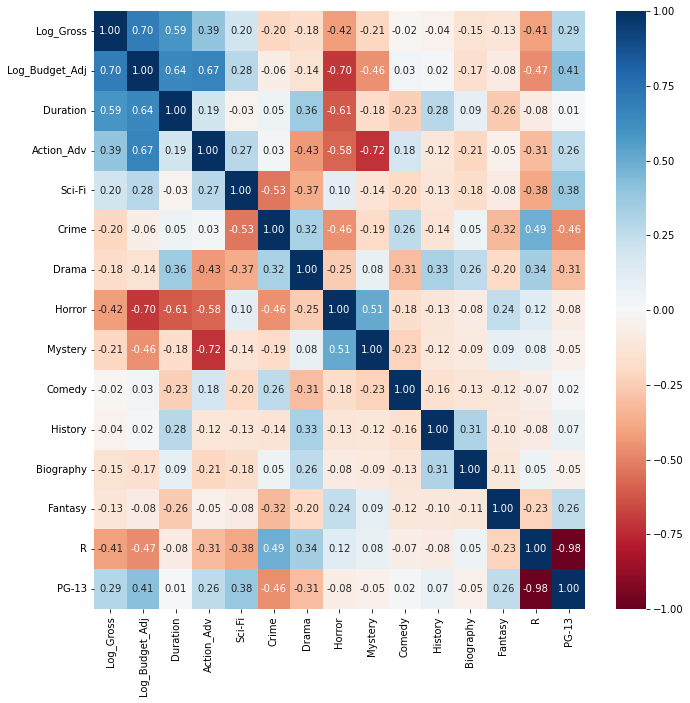

In [53]:
# seaborn correlation heatmap
fig, ax = plt.subplots(figsize=(11,11))
#center set to white - judge positive and negative correlation on equal footing 
#vmin/vmax specifices what values will start and end color map
#fmt tells seaborn how many decimal places we want
sns.heatmap(get_corr.corr(), cmap='RdBu', center=0, vmin=-1, vmax=1, annot=True, fmt = '.2f')

In [54]:
sns.set_style('darkgrid')

https://stackoverflow.com/questions/53717543/reduce-number-of-plots-in-sns-pairplot

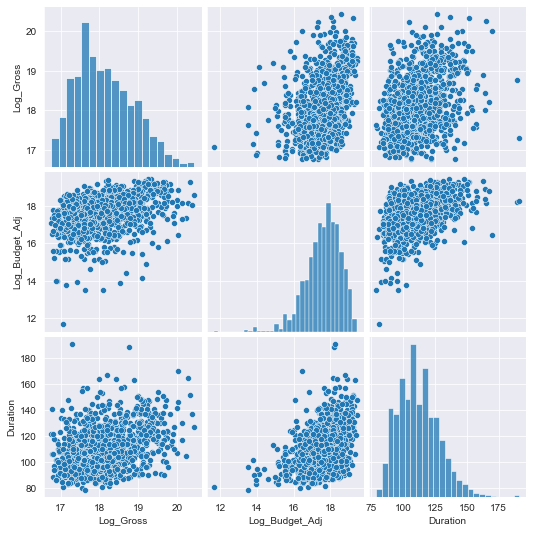

In [55]:
sns.pairplot(first_set, vars = ['Log_Gross', 'Log_Budget_Adj', 'Duration'])

<AxesSubplot:xlabel='Log_Budget_Adj', ylabel='Log_Gross'>

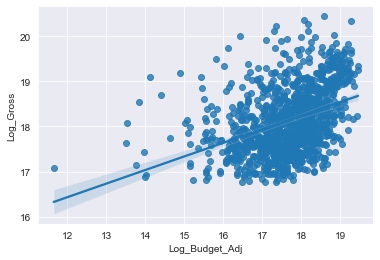

In [56]:
plt.ticklabel_format(style='plain')
sns.set(rc={"figure.figsize":(12, 8)}) #width, height
sns.regplot(x='Log_Budget_Adj', y='Log_Gross', data=first_set)